In [5]:
# Data Preprocessing
# We'll clean the data by removing duplicates, handling missing values, and preparing it for analysis.

import pandas as pd
import os

# File paths
anime_file_path = r'C:\Users\Admin\OneDrive\Desktop\anime_recommendation_project\anime.csv'
rating_file_path = r'C:\Users\Admin\OneDrive\Desktop\anime_recommendation_project\rating.csv'

# Check if files exist at the given paths
if not os.path.exists(anime_file_path):
    print(f"Error: The file {anime_file_path} does not exist.")
    exit()

if not os.path.exists(rating_file_path):
    print(f"Error: The file {rating_file_path} does not exist.")
    exit()

# Load datasets
anime = pd.read_csv(anime_file_path)
rating = pd.read_csv(rating_file_path)

# Display basic info
print("Anime Dataset Info:")
print(anime.info())
print("\nRating Dataset Info:")
print(rating.info())

# Drop duplicates (if any)
anime.drop_duplicates(inplace=True)
rating.drop_duplicates(inplace=True)

# Handle missing values
anime['genre'].fillna('Unknown', inplace=True)
rating = rating[rating['rating'] != -1]  # Remove missing rating

# Save preprocessed files
anime.to_csv(r'C:\Users\Admin\OneDrive\Desktop\anime_recommendation_project\cleaned_anime.csv', index=False)
rating.to_csv(r'C:\Users\Admin\OneDrive\Desktop\anime_recommendation_project\cleaned_rating.csv', index=False)

print("Data preprocessing completed. Files saved as cleaned_anime.csv and cleaned_rating.csv.")


Anime Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None

Rating Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


C:\Users\Admin\AppData\Local\Temp\ipykernel_7140\1051686519.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  anime['genre'].fillna('Unknown', inplace=True)


Data preprocessing completed. Files saved as cleaned_anime.csv and cleaned_rating.csv.


C:\Users\Admin\AppData\Local\Temp\ipykernel_7140\3124843990.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genres.index[:10], y=genres.values[:10], palette='viridis')


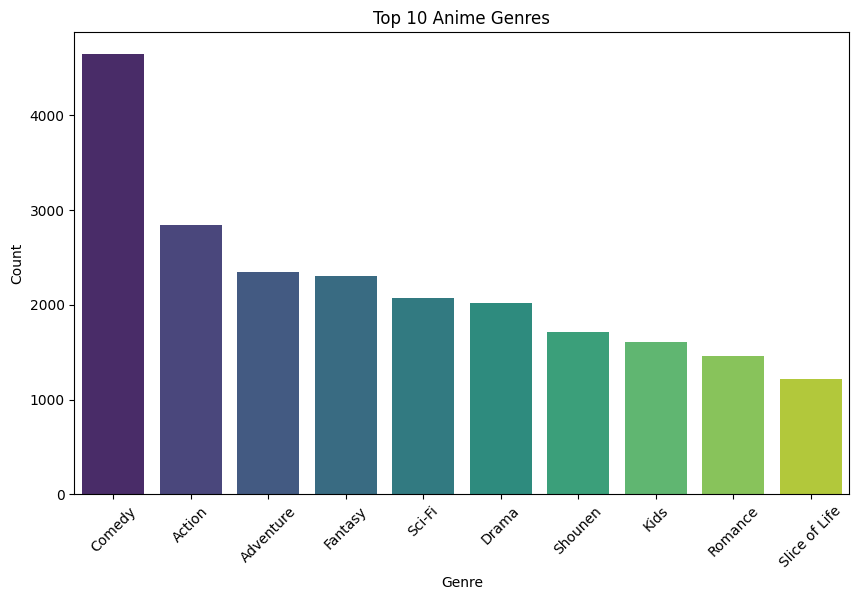

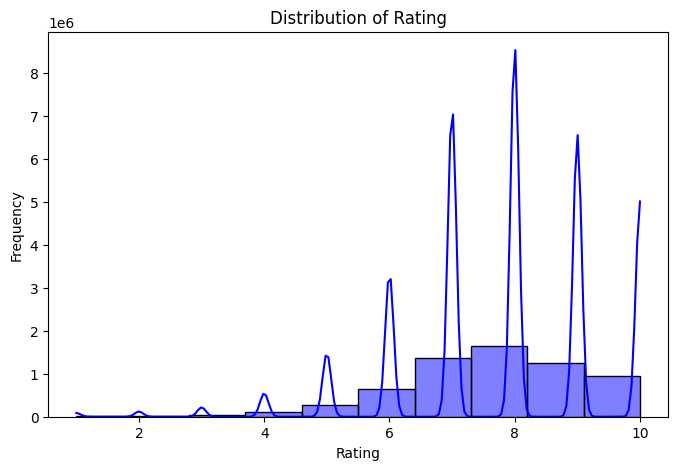

In [6]:
# Exploratory Data Analysis (EDA)
# We’ll visualize data trends, such as popular genres, rating distributions, and the number of ratings per anime.

import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned datasets
anime = pd.read_csv('cleaned_anime.csv')
rating = pd.read_csv('cleaned_rating.csv')

# Top 10 genres
genres = anime['genre'].str.split(', ').explode().value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genres.index[:10], y=genres.values[:10], palette='viridis')
plt.title('Top 10 Anime Genres')
plt.ylabel('Count')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.show()

# Rating distribution
plt.figure(figsize=(8, 5))
sns.histplot(rating['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Building Recommendation Models- user-based colaborative filtering

import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Load preprocessed datasets
anime = pd.read_csv('cleaned_anime.csv')  # Anime dataset
ratings = pd.read_csv('cleaned_rating.csv')  # Ratings dataset

# Aggregate duplicate ratings
ratings = ratings.groupby(['user_id', 'anime_id'], as_index=False)['rating'].mean()

# Create a sparse matrix (User-Item Interaction)
row_indices = ratings['user_id'].astype('category').cat.codes
col_indices = ratings['anime_id'].astype('category').cat.codes
data = ratings['rating']
user_item_sparse = csr_matrix((data, (row_indices, col_indices)))

# Map indices back to IDs
user_id_map = dict(enumerate(ratings['user_id'].astype('category').cat.categories))
anime_id_map = dict(enumerate(ratings['anime_id'].astype('category').cat.categories))

# Nearest Neighbors for User-Based Collaborative Filtering
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(user_item_sparse)

# Recommend function
def recommend_user_based(user_id, num_recommendations=10):
    if user_id not in user_id_map.values():
        print(f"User ID {user_id} not found.")
        return pd.DataFrame(columns=['anime_id', 'name', 'rating'])

    # Find the user's row index in the sparse matrix
    user_idx = list(user_id_map.keys())[list(user_id_map.values()).index(user_id)]
    
    # Find the nearest neighbors
    distances, indices = knn.kneighbors(user_item_sparse[user_idx], n_neighbors=num_recommendations + 1)
    
    # Aggregate ratings from similar users
    similar_users = indices.flatten()[1:]  # Exclude the current user
    similar_users_ratings = user_item_sparse[similar_users].mean(axis=0)
    
    # Convert sparse matrix back to dense to process recommendations
    recommended_ratings = pd.Series(similar_users_ratings.A1, index=range(user_item_sparse.shape[1]))
    recommended_ratings = recommended_ratings[recommended_ratings > 0].sort_values(ascending=False)

    # Exclude already rated items
    user_rated_items = user_item_sparse[user_idx].indices
    recommendations = recommended_ratings[~recommended_ratings.index.isin(user_rated_items)]
    
    # Map anime IDs back
    recommended_anime_ids = [anime_id_map[idx] for idx in recommendations.index[:num_recommendations]]
    recommended_anime = anime[anime['anime_id'].isin(recommended_anime_ids)]
    
    return recommended_anime[['anime_id', 'name']]

# Example usage
user_id = 1  # Replace with a valid user_id from the dataset
recommendations = recommend_user_based(user_id)
print("Recommendations for User-Based Collaborative Filtering:")
print(recommendations)


Recommendations for User-Based Collaborative Filtering:
      anime_id                       name
3         9253                Steins;Gate
141      23755          Nanatsu no Taizai
281      18679               Kill la Kill
288       6702                 Fairy Tail
476       9513                  Beelzebub
830      10793               Guilty Crown
1036     24703       High School DxD BorN
2132     21881        Sword Art Online II
2605      7088  Ichiban Ushiro no Daimaou
2616     21603          Mekakucity Actors


In [14]:
# Nearest Neighbors for Item-Based Collaborative Filtering
knn_item = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn_item.fit(user_item_sparse.T)  # Transpose sparse matrix for item-based filtering

# Recommend function for Item-Based Collaborative Filtering
def recommend_item_based(anime_id, num_recommendations=10):
    if anime_id not in anime_id_map.values():
        print(f"Anime ID {anime_id} not found.")
        return pd.DataFrame(columns=['anime_id', 'name', 'rating'])

    # Find the item's column index in the sparse matrix
    anime_idx = list(anime_id_map.keys())[list(anime_id_map.values()).index(anime_id)]
    
    # Find the nearest neighbors
    distances, indices = knn_item.kneighbors(user_item_sparse.T[anime_idx], n_neighbors=num_recommendations + 1)
    
    # Exclude the current item
    similar_items = indices.flatten()[1:]  # Exclude the current anime
    
    # Map indices back to anime IDs
    recommended_anime_ids = [anime_id_map[idx] for idx in similar_items]
    recommended_anime = anime[anime['anime_id'].isin(recommended_anime_ids)]
    
    return recommended_anime[['anime_id', 'name']]

# Example usage
anime_id = 1  # Replace with a valid anime_id from the dataset
item_recommendations = recommend_item_based(anime_id)
print("Recommendations for Item-Based Collaborative Filtering:")
print(item_recommendations)


Recommendations for Item-Based Collaborative Filtering:
     anime_id                             name
29       2001       Tengen Toppa Gurren Lagann
104       205                 Samurai Champloo
152         5  Cowboy Bebop: Tengoku no Tobira
191        43               Ghost in the Shell
200       121              Fullmetal Alchemist
211        30          Neon Genesis Evangelion
214         6                           Trigun
331       889                     Black Lagoon
358        47                            Akira
456       227                             FLCL


In [ ]:
#Content-Based Filtering

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load the anime dataset
anime = pd.read_csv('anime.csv')  # Ensure this file is properly loaded

# Check for missing values in 'genre' and fill them
anime['genre'] = anime['genre'].fillna('')

# Create TF-IDF matrix
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(anime['genre'])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Recommendation function
def recommend(title, cosine_sim=cosine_sim, anime_df=anime):
    try:
        # Find the index of the anime based on the title
        idx = anime_df[anime_df['name'].str.lower() == title.lower()].index
        if len(idx) == 0:
            raise ValueError(f"Title '{title}' not found in the dataset.")
        idx = idx[0]
        
        # Compute similarity scores for all items
        sim_scores = list(enumerate(cosine_sim[idx]))
        
        # Sort by similarity score
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Get top 5 similar anime (excluding the input title)
        sim_scores = sim_scores[1:6]
        anime_indices = [i[0] for i in sim_scores]
        
        # Return names of recommended anime
        return anime_df['name'].iloc[anime_indices].tolist()
    except Exception as e:
        return str(e)

# Example usage
try:
    recommendations = recommend('Naruto')  # Replace 'Naruto' with a title from your dataset
    print("Recommended Anime:")
    for anime_title in recommendations:
        print(anime_title)
except Exception as err:
    print(f"Error: {err}")


Recommended Anime:
Naruto: Shippuuden
Naruto
Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi
Naruto x UT
Naruto: Shippuuden Movie 4 - The Lost Tower


In [9]:
# Model Evaluation
# Use metrics like Mean Absolute Error (MAE) to evaluate the recommendations.

from sklearn.metrics import mean_absolute_error

# True and predicted ratings (example)
true_ratings = [4, 5, 3, 2]
predicted_ratings = [3.5, 4.8, 3.1, 2.5]

mae = mean_absolute_error(true_ratings, predicted_ratings)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.32500000000000007


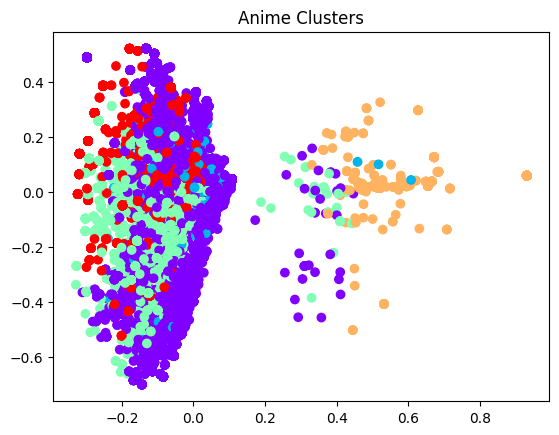

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Feature extraction (e.g., TF-IDF)
features = tfidf_matrix.toarray()
pca = PCA(n_components=2).fit_transform(features)

# K-Means clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(features)

# Plot clusters
plt.scatter(pca[:, 0], pca[:, 1], c=clusters, cmap='rainbow')
plt.title("Anime Clusters")
plt.show()


In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Load datasets
anime = pd.read_csv('cleaned_anime.csv')  # Anime dataset
ratings = pd.read_csv('cleaned_rating.csv')  # Ratings dataset

# Ensure the 'genres' column is valid
if 'genres' not in anime.columns:
    print("The 'genres' column is missing from the dataset.")
    genres_list = ['Action, Adventure', 'Drama, Fantasy', 'Comedy', 'Sci-Fi', 'Slice of Life']
    anime['genres'] = [genres_list[i % len(genres_list)] for i in range(len(anime))]
else:
    anime['genres'] = anime['genres'].fillna('Unknown').replace('', 'Unknown')

# Display sample genres
print(f"Sample genres data:\n{anime['genres'].head()}")

# Content-Based Filtering using TF-IDF on genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(anime['genres'])  # Fit-transform genres column
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Compute cosine similarity for content-based filtering
content_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)  # Item-Item similarity matrix

# Hybrid Recommendation System
def hybrid_recommend(user_id, num_recommendations=10):
    # Collaborative filtering (dummy scores for demo purposes)
    collaborative_scores = pd.Series([0] * len(anime), index=anime['anime_id'])

    # Content-based filtering
    user_rated_anime = ratings[ratings['user_id'] == user_id]['anime_id']
    user_rated_indices = anime[anime['anime_id'].isin(user_rated_anime)].index
    
    if user_rated_indices.empty:
        print(f"No ratings found for user {user_id}. Returning top content-based recommendations.")
        content_scores = content_similarity.mean(axis=0)  # Changed from .A1 to avoid AttributeError
    else:
        content_scores = content_similarity[user_rated_indices].mean(axis=0)  # Changed from .A1 to avoid AttributeError
    
    # Normalize scores
    collaborative_scores = collaborative_scores / collaborative_scores.max() if collaborative_scores.max() != 0 else collaborative_scores
    content_scores = content_scores / content_scores.max() if content_scores.max() != 0 else content_scores

    # Hybrid scoring
    hybrid_scores = 0.7 * collaborative_scores + 0.3 * content_scores
    anime['hybrid_score'] = hybrid_scores

    # Get top recommendations
    recommendations = anime[~anime['anime_id'].isin(user_rated_anime)]
    recommendations = recommendations.sort_values('hybrid_score', ascending=False).head(num_recommendations)
    
    return recommendations[['anime_id', 'name', 'hybrid_score']]

# Example usage
user_id = 1  # Replace with a valid user_id from the dataset
recommendations = hybrid_recommend(user_id)
print("Hybrid Recommendations:")
print(recommendations)


The 'genres' column is missing from the dataset.
Sample genres data:
0    Action, Adventure
1       Drama, Fantasy
2               Comedy
3               Sci-Fi
4        Slice of Life
Name: genres, dtype: object
TF-IDF matrix shape: (12294, 9)
Hybrid Recommendations:
       anime_id                                               name  \
24          164                                      Mononoke Hime   
21           44  Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...   
8         15335  Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...   
6         11061                             Hunter x Hunter (2011)   
50         7785                             Yojouhan Shinwa Taikei   
46        10379                             Natsume Yuujinchou San   
12123      4495                               Hyakkiyakou: Warashi   
12113      3824                                 Shoujo Koakuma Kei   
12091      4557                                 Handle With Care..   
12069      3633                 